#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import variation, pearsonr
from datetime import timedelta

import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Settings
pd.options.display.float_format = '{:.2f}'.format

#### Importing data

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
stores = pd.read_csv('Data/stores.csv')
transactions = pd.read_csv('Data/transactions.csv')
holidays_events = pd.read_csv('Data/holidays_events.csv')
oil = pd.read_csv('Data/oil.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv')

In [3]:
print(len(train))
train.head()

3000888


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [4]:
print(len(test))
test.head()

28512


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [5]:
print(len(sample_submission)) # same length as test
sample_submission.head()

28512


,id,sales
0,3000888,0.00
1,3000889,0.00
2,3000890,0.00
3,3000891,0.00
4,3000892,0.00


In [6]:
print(len(stores))
stores.head()

54


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
print(len(transactions))
transactions.head()

83488


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [8]:
print(len(holidays_events)) # same length as test
holidays_events.head()

350


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
print(len(oil)) # same length as test
oil.head()

1218


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


#### Ideas
- Can expect correlation between sales and onpromotion (number of items in product family under promotion on given date). More the number of products on promotion in family greater the sales
- Can expect correlation between sales and oil prices
- Is not a holiday: 'Transferred' (Column transferred True), 'Work Day'; Is a Holiday: 'Holiday', 'Transfer', 'Additional', 'Bridge'
- Can add inidcator for 15th and last day of month since wages are paid
- Add indicator or remove weeks after earthquake April 16, 2016

#### Processing data

##### Processing holiday and events data

In [10]:
holidays_events_proc = holidays_events.copy()
holidays_events_proc.head(2)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


In [11]:
holidays_events_proc['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [12]:
# Event is not a holiday. It includes Earthquake, Black friday, etc.
holidays_events_proc[holidays_events_proc['type']=='Event'].reset_index(drop=True).iloc[16:23]

,date,type,locale,locale_name,description,transferred
16,2014-11-28,Event,National,Ecuador,Black Friday,False
17,2014-12-01,Event,National,Ecuador,Cyber Monday,False
18,2015-05-10,Event,National,Ecuador,Dia de la Madre,False
19,2015-11-27,Event,National,Ecuador,Black Friday,False
20,2015-11-30,Event,National,Ecuador,Cyber Monday,False
21,2016-04-16,Event,National,Ecuador,Terremoto Manabi,False
22,2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False


In [13]:
print('Locale values:', holidays_events_proc['locale'].unique())
print(holidays_events_proc[['locale', 'locale_name']].drop_duplicates()['locale'].value_counts())
# 4 Regions, 19 locales are present in holidays file

print('Levels at which Events are present:', 
holidays_events_proc[holidays_events_proc['type']=='Event']['locale'].unique())
# All events are at National level only

holidays_events_proc[['locale', 'locale_name']].drop_duplicates().sort_values(by=['locale'])

Locale values: ['Local' 'Regional' 'National']
Local       19
Regional     4
National     1
Name: locale, dtype: int64
Levels at which Events are present: ['National']


,locale,locale_name
0,Local,Manta
30,Local,Loja
28,Local,Quito
18,Local,Quevedo
17,Local,Ibarra
16,Local,Ambato
13,Local,Esmeraldas
12,Local,Cayambe
32,Local,Salinas
10,Local,Santo Domingo


In [14]:
events_list = holidays_events_proc[(holidays_events_proc['type']=='Event')]['description'].unique().tolist()

# Changing all strings to lower case
events_list = [str.lower(i) for i in events_list]

# Naming different days of football match the same - Based on description Ecuador’s 
# matches were only on 3 of the days.
events_list = ['mundial de futbol brasil' if ('mundial de futbol brasil' in i) else i for i in events_list]

# Removing suffixes (-1, -2, +1, etc.) for days before and after events
events_list = [i[:i.rfind('-')] if ('-' in i) else (
    i[:i.rfind('+')]  if ('+' in i) else i) for i in events_list]

# 'terremoto manabi' - Earthquake
events_list = np.unique(events_list)
print('Number of unique events:', len(events_list), '\n', events_list)

Number of unique events: 5 
 ['black friday' 'cyber monday' 'dia de la madre'
 'mundial de futbol brasil' 'terremoto manabi']


In [15]:
holidays_events_proc['description'].isna().sum()

0

In [16]:
# Adding flag for Event
holidays_events_proc['Event'] = holidays_events_proc['type'] == 'Event'

# Repeating same steps as above
holidays_events_proc['Event_name_base'] = holidays_events_proc['description'].str.lower()
holidays_events_proc['Event_name_base'] = holidays_events_proc['Event_name_base'].map(
    lambda i: 'mundial de futbol brasil' if ('mundial de futbol brasil' in i) else i) 
holidays_events_proc['Event_name_base'] = holidays_events_proc['Event_name_base'].map(
    lambda i: i[:i.rfind('-')] if ('-' in i) else (
    i[:i.rfind('+')]  if ('+' in i) else i)) 
holidays_events_proc['Event_name_base'] = np.where(
    holidays_events_proc['Event']==True, 
    holidays_events_proc['Event_name_base'], None)

holidays_events_proc[holidays_events_proc['type']=='Event'].reset_index(drop=True).iloc[16:18]

,date,type,locale,locale_name,description,transferred,Event,Event_name_base
16,2014-11-28,Event,National,Ecuador,Black Friday,False,True,black friday
17,2014-12-01,Event,National,Ecuador,Cyber Monday,False,True,cyber monday


Check 'cantonizacion', 'recupero', 'dia', 'fundacion', 'primer', 'independencia', 'provincializacion'
-  'cantonizacion' - occurs as 'cantonizacion' de 'locale_name'
-  'fundacion' - occurs as 'fundacion' de 'locale_name'
-  'provincializacion' - occurs as 'provincializacion' de 'locale_name'
-  'independencia' - occurs as 'independencia' de 'locale_name' and independencia de Cuenca/ Guayaquil at National level but Cuenca, Guayaquil are also locale names
- Appears like 'puente' is bridge and 'recupero puente' is work day compensating for bridge
-  'dia', 'primer' - All at national level. no other pattern observed

In [17]:
holidays_list = holidays_events_proc[(holidays_events_proc['Event']!=True) & 
(holidays_events_proc['transferred']==False) & 
(holidays_events_proc['type']!='Work Day')]['description'].unique().tolist()

# Changing all strings to lower case
holidays_list = [str.lower(i) for i in holidays_list]

# Removing prefix 'traslado' for transferred holidays
holidays_list = [i[len('traslado '):] if ('traslado' in i) else i for i in holidays_list]

# Removing prefix 'puente' for bridge holidays
holidays_list = [i[len('puente '):] if ('puente' in i) else i for i in holidays_list]

# Removing prefix 'Traslado' for transferred holidays
holidays_list = [i[len('recupero puente '):] if ('recupero puente' in i) else i for i in holidays_list]

# Removing suffixes (-1, -2, +1, etc.) for days before and after holidays
holidays_list = [i[:i.rfind('-')] if ('-' in i) else (
    i[:i.rfind('+')]  if ('+' in i) else i) for i in holidays_list]


holidays_list = np.unique(holidays_list)
print('Number of unique holidays:', len(holidays_list), '\n', holidays_list)

Number of unique holidays: 38 
 ['batalla de pichincha' 'cantonizacion de cayambe'
 'cantonizacion de el carmen' 'cantonizacion de guaranda'
 'cantonizacion de latacunga' 'cantonizacion de libertad'
 'cantonizacion de quevedo' 'cantonizacion de riobamba'
 'cantonizacion de salinas' 'cantonizacion del puyo' 'carnaval'
 'dia de difuntos' 'dia de la madre' 'dia del trabajo'
 'fundacion de ambato' 'fundacion de cuenca' 'fundacion de esmeraldas'
 'fundacion de guayaquil' 'fundacion de ibarra' 'fundacion de loja'
 'fundacion de machala' 'fundacion de manta' 'fundacion de quito'
 'fundacion de riobamba' 'fundacion de santo domingo'
 'independencia de ambato' 'independencia de cuenca'
 'independencia de guaranda' 'independencia de guayaquil'
 'independencia de latacunga' 'navidad' 'primer dia del ano'
 'primer grito de independencia' 'provincializacion de cotopaxi'
 'provincializacion de imbabura' 'provincializacion de santo domingo'
 'provincializacion santa elena' 'viernes santo']


In [18]:
# Adding holiday flag
holidays_events_proc['Holiday'] = (
    (holidays_events_proc['Event']!=True) & 
    (holidays_events_proc['transferred']==False) & 
    (holidays_events_proc['type']!='Work Day'))

# Repeating same steps as above
holidays_events_proc['Holiday_name_base'] =  holidays_events_proc['description'].str.lower()
holidays_events_proc['Holiday_name_base'] = holidays_events_proc['Holiday_name_base'].map(
    lambda i: i[len('traslado '):] if ('traslado' in i) else i)
holidays_events_proc['Holiday_name_base'] = holidays_events_proc['Holiday_name_base'].map(
    lambda i: i[len('puente '):] if ('puente' in i) else i) 
holidays_events_proc['Holiday_name_base'] = holidays_events_proc['Holiday_name_base'].map(
    lambda i: i[len('recupero puente '):] if ('recupero puente' in i) else i) 
holidays_events_proc['Holiday_name_base'] = holidays_events_proc['Holiday_name_base'].map(
    lambda i: i[:i.rfind('-')] if ('-' in i) else (
    i[:i.rfind('+')]  if ('+' in i) else i)) 
holidays_events_proc['Holiday_name_base'] =  np.where(
    holidays_events_proc['Holiday']==True, 
    holidays_events_proc['Holiday_name_base'], None)

holidays_events_proc.head(3)

,date,type,locale,locale_name,description,transferred,Event,Event_name_base,Holiday,Holiday_name_base
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,False,None,True,fundacion de manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,False,None,True,provincializacion de cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,False,None,True,fundacion de cuenca


##### Processing and exploring train data set

In [19]:
# Exploring train data set
train['date'] = pd.to_datetime(train['date'])
data_start_date = train['date'].min()
data_end_date = train['date'].max()
print(data_start_date, data_end_date)
train.head()

2013-01-01 00:00:00 2017-08-15 00:00:00


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [20]:
# 75% of sales values are below 200 but maximum sales is 100 thousand
# Average number of items on promotion is 2 and 75% of onpromotion values is 0, maximum is 741 items
train[['sales', 'onpromotion']].describe()

,sales,onpromotion
count,3000888.00,3000888.00
mean,357.78,2.60
std,1102.00,12.22
min,0.00,0.00
25%,0.00,0.00
50%,11.00,0.00
75%,195.85,0.00
max,124717.00,741.00


In [21]:
# Every store-product combination present in train data
print('Unique store count:', train['store_nbr'].nunique(), '\n', 
'Unique product family count:', train['family'].nunique(),  '\n', 
'Unique store, product family combinations:', 
train[['store_nbr', 'family']].drop_duplicates().shape[0])
54*33


Unique store count: 54 
 Unique product family count: 33 
 Unique store, product family combinations: 1782


1782

In [22]:
# Column indicating store, product family combination
train_proc = train.copy()
train_proc['comb'] = train_proc['store_nbr'].map(int).map(str) + '_' + train_proc['family']
train_proc.head(2)

,id,date,store_nbr,family,sales,onpromotion,comb
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0,1_AUTOMOTIVE
1,1,2013-01-01,1,BABY CARE,0.00,0,1_BABY CARE


In [23]:
# Separating combinations with no sales so that they can directly be assinged as zero
no_sales_combs = list(set(train_proc['comb'].unique()) - # all combs
set(train_proc[train_proc['sales']!=0]['comb'].unique())) # combs with non-zero sales
no_sales_inlstyr_combs = list(set(train_proc['comb'].unique()) - # all combs
set(train_proc[(train_proc['date']>=(data_end_date-timedelta(days=366))) & 
(train_proc['sales']!=0)]['comb'].unique())) # combs with non-zero sales in last year
print('Count of combinations with no sales:', len(no_sales_combs))
print('Count of combinations with no sales in last year:', len(no_sales_inlstyr_combs))

Count of combinations with no sales: 53
Count of combinations with no sales in last year: 65


###### Demand type classification
![](demand_classification.png)
- Smooth demand (ADI < 1.32 and CV² < 0.49). The demand is very regular in time and in quantity. It is therefore easy to forecast and you won’t have trouble reaching a low forecasting error level. 
- Intermittent demand (ADI >= 1.32 and CV² < 0.49). The demand history shows very little variation in demand quantity but a high variation in the interval between two demands. Though specific forecasting methods tackle intermittent demands, the forecast error margin is considerably higher.
- Erratic demand (ADI < 1.32 and CV² >= 0.49). The demand has regular occurrences in time with high quantity variations. Your forecast accuracy remains shaky.
- Lumpy demand (ADI >= 1.32 and CV² >= 0.49). The demand is characterized by a large variation in quantity and in time. It is actually impossible to produce a reliable forecast, no matter which forecasting tools you use. This particular type of demand pattern is unforecastable.

In [24]:
# Demand classification, Missing days count, Years of data present

def comb_info_calc(df):
    """" Function calculates Average sales, duration, 
    count of missing dates, adi, cv^2.
    df: data frame with date and sales columns
    """
    # ADI 
    df1 = df[df['sales']!=0].copy()
    df_act = df[df['date']>=df1['date'].min()].copy()
    avg_sales = df_act['sales'].mean()
    days_pres = len(df_act)
    df_all_dates = pd.DataFrame({'date': pd.date_range(
        start=df1['date'].min(), end=data_end_date)})
    df_act = df_act.merge(df_all_dates, on=['date'], how='right')
    days_tot = len(df_act)
    df_act['sales'] = df_act['sales'].fillna(0)
    adi = len(df_all_dates)/df_act[df_act['sales']!=0].shape[0]

    # CV
    cv2 = variation(df_act['sales'])

    # Correlation with onpromotion
    df_act['onpromotion'] = df_act['onpromotion'].fillna(0)
    if ((df_act['onpromotion'].nunique()==1) |
    (df_act['onpromotion'].nunique()==1)):
        corr_val = 0
    else:
        corr_val = pearsonr(df_act['onpromotion'], df_act['sales'])[0]

    return([avg_sales, days_tot, days_tot-days_pres, corr_val, adi, cv2])

# Keeping only combs with sales
train_proc_sales = train_proc[train_proc['comb'].isin(no_sales_inlstyr_combs)==False].copy()

comb_info_tb = train_proc_sales.groupby('comb').apply(
    comb_info_calc).reset_index().rename(columns={0: 'COMB_INFO'})
comb_info_tb['Avg_sales'] = comb_info_tb['COMB_INFO'].map(lambda x: x[0])
comb_info_tb['Total_days'] = comb_info_tb['COMB_INFO'].map(lambda x: x[1])
comb_info_tb['Missing_days'] = comb_info_tb['COMB_INFO'].map(lambda x: x[2])
comb_info_tb['Corr_onpromo'] = comb_info_tb['COMB_INFO'].map(lambda x: x[3])

comb_info_tb['Years_of_data'] = comb_info_tb['Total_days']/365

# Calculating adi, cv^2 and demand classification
comb_info_tb['ADI'] = comb_info_tb['COMB_INFO'].map(lambda x: x[4])
comb_info_tb['CV2'] = comb_info_tb['COMB_INFO'].map(lambda x: x[5])
comb_info_tb.drop(columns=['COMB_INFO'], inplace=True)

comb_info_tb['Demand_classification'] = np.where(
    (comb_info_tb['ADI']<1.32) & (comb_info_tb['CV2']<0.49), 'Smooth',
    np.where((comb_info_tb['ADI']>=1.32) & (comb_info_tb['CV2']<0.49), 'Intermittent',
    np.where((comb_info_tb['ADI']<1.32) & (comb_info_tb['CV2']>=0.49), 'Erratic', 'Lumpy'))
)

print(comb_info_tb['Demand_classification'].value_counts().reset_index())
comb_info_tb.head()

     index  Demand_classification
0  Erratic                    797
1   Smooth                    517
2    Lumpy                    403


,comb,Avg_sales,Total_days,Missing_days,Corr_onpromo,Years_of_data,ADI,CV2,Demand_classification
0,10_AUTOMOTIVE,3.08,1687,4,0.14,4.62,1.14,0.86,Erratic
1,10_BABY CARE,0.40,1142,3,0.09,3.13,6.92,3.41,Lumpy
2,10_BEAUTY,1.37,1687,4,0.23,4.62,1.47,1.03,Lumpy
3,10_BEVERAGES,895.63,1687,4,0.49,4.62,1.00,0.47,Smooth
4,10_BREAD/BAKERY,113.74,1687,4,0.24,4.62,1.00,0.33,Smooth


In [25]:
# 75% of the combinations have >=3.5 years of data, Maximum number of dates missing is 4
comb_info_tb[['Years_of_data', 'Missing_days', 'Total_days']].describe()

,Years_of_data,Missing_days,Total_days
count,1717.00,1717.00,1717.00
mean,3.89,3.37,1420.33
std,1.06,0.90,386.98
min,0.10,0.00,37.00
25%,3.62,3.00,1322.00
50%,4.62,4.00,1687.00
75%,4.62,4.00,1687.00
max,4.62,4.00,1688.00


###### DO THIS - Adding missing dates and imputing values

In [86]:
def fill_missing(df):
    """" Function adds missing dates
    and fill sales value.
    df: data frame with date and sales columns for one
    store product combination
    """
    
    df1 = df[df['sales']!=0].copy()
    df_act = df[df['date']>=df1['date'].min()].copy()
    
    if(df_act['comb'].nunique()!=1):
        print(df_act['comb'].unique())

    df_all_dates = pd.DataFrame({'date': pd.date_range(
        start=df1['date'].min(), end=data_end_date, freq='1D')})
    df_all_dates = df_all_dates[['date']].drop_duplicates()
    df_act = df_act.merge(df_all_dates, on=['date'], how='right')
    
    if (df_act.shape[0]!=df_act[['date', 'comb']].drop_duplicates().shape[0]):
        print(df_act['comb'].unique())

    df_act['sales_shift1'] = df_act['sales'].shift(1)
    df_act['sales_shift7'] = df_act['sales'].shift(7)
    df_act['sales_shift-1'] = df_act['sales'].shift(-1)
    df_act['sales_shift-7'] = df_act['sales'].shift(-7)
    
    df_act['sales'] = np.where(df_act['sales'].isna(),
    np.where(df_act['sales_shift7'].isna()==False, df_act['sales_shift7'],
    np.where(df_act['sales_shift-7'].isna()==False, df_act['sales_shift-7'],
    np.where(df_act['sales_shift1'].isna()==False, df_act['sales_shift1'],
    df_act['sales_shift-1']))),
    df_act['sales'])
    
    if (df_act['sales'].isna().sum()!=0):
        print(df_act['comb'].unique())

    if (df_act.shape[0]!=df_act[['date', 'comb']].drop_duplicates().shape[0]):
        print(2, ', ', df_act['comb'].unique())


    return(df_act[df.columns])

train_proc_sales_fill = train_proc_sales.groupby(['comb']).apply(fill_missing).reset_index(drop=True)

In [85]:
train_proc_sales.shape, train_proc_sales[['date', 'comb']].drop_duplicates().shape, train_proc_sales_fill.shape, train_proc_sales_fill[['date', 'comb']].drop_duplicates().shape

((2891428, 7), (2891428, 2), (2438705, 7), (2432921, 2))

In [60]:
# Export for R
train_proc_sales_fill.to_csv('Intermediate data/train_proc_sales_fill.csv', index=False)

###### Exploring onpromotion variable

Correlation between sales and onpromotion: PearsonRResult(statistic=0.42652281703927936, pvalue=0.0)


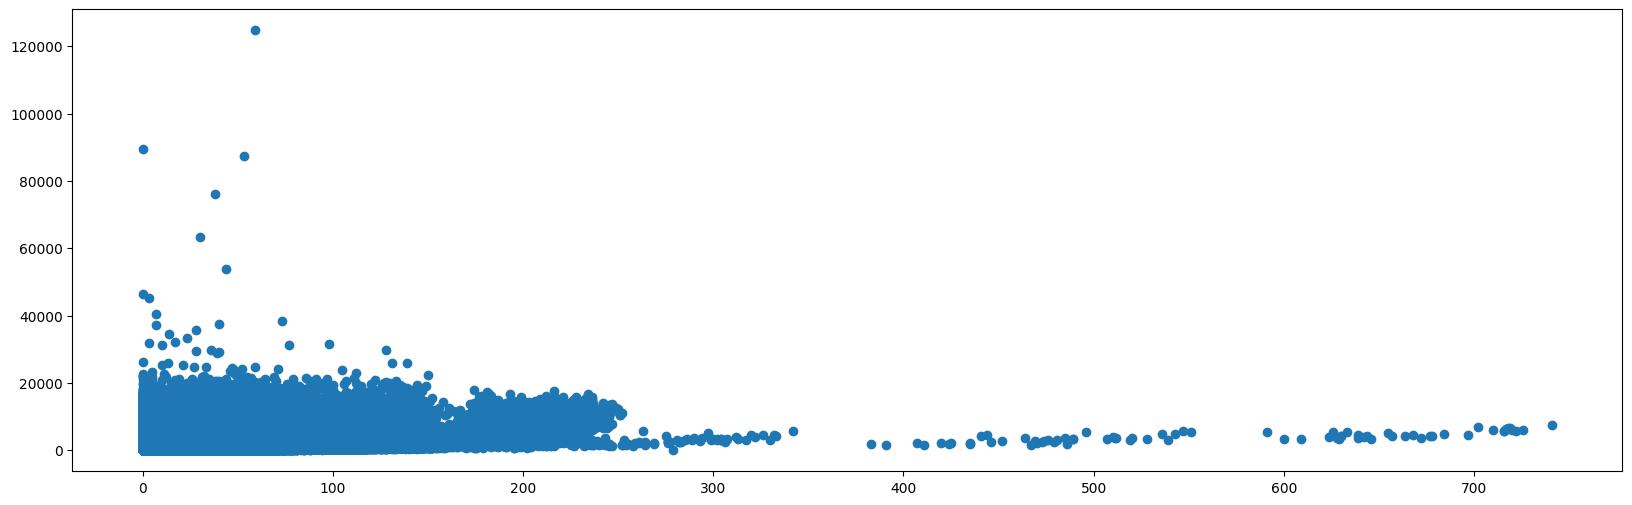

In [26]:
print('Correlation between sales and onpromotion:', 
pearsonr(train_proc_sales['onpromotion'], train_proc_sales['sales']))
# train_proc_sales.head()

plt.figure(figsize=(20, 6))
plt.plot(train_proc_sales['onpromotion'], 
train_proc_sales['sales'], marker='o', linewidth=0)
plt.show()

count   1717.00
mean       0.20
std        0.18
min       -0.25
25%        0.05
50%        0.17
75%        0.32
max        0.88
Name: Corr_onpromo, dtype: float64


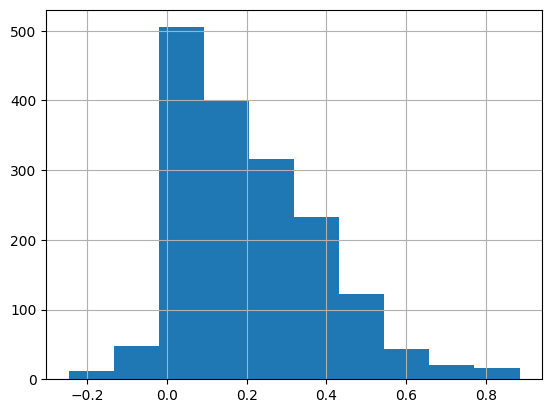

In [27]:
print(comb_info_tb['Corr_onpromo'].describe())
comb_info_tb['Corr_onpromo'].hist()
plt.show()

In [28]:
comb_info_tb[comb_info_tb['Corr_onpromo']>=0.8]

,comb,Avg_sales,Total_days,Missing_days,Corr_onpromo,Years_of_data,ADI,CV2,Demand_classification
213,16_SCHOOL AND OFFICE SUPPLIES,3.13,751,2,0.85,2.06,6.26,3.54,Lumpy
658,29_PRODUCE,1243.11,807,2,0.81,2.21,1.00,0.46,Smooth
723,30_SCHOOL AND OFFICE SUPPLIES,1.19,1140,3,0.87,3.12,10.96,4.35,Lumpy
785,32_SCHOOL AND OFFICE SUPPLIES,2.85,491,1,0.81,1.35,4.31,2.88,Lumpy
815,33_SCHOOL AND OFFICE SUPPLIES,2.98,607,2,0.88,1.66,5.57,3.17,Lumpy
877,35_SCHOOL AND OFFICE SUPPLIES,2.04,621,2,0.85,1.70,4.89,3.13,Lumpy
909,36_SCHOOL AND OFFICE SUPPLIES,6.13,1322,3,0.81,3.62,2.36,4.18,Lumpy
1071,40_SCHOOL AND OFFICE SUPPLIES,2.97,1142,3,0.88,3.13,8.85,4.36,Lumpy
1425,50_SCHOOL AND OFFICE SUPPLIES,14.36,1322,3,0.81,3.62,1.40,3.73,Lumpy
1551,54_SCHOOL AND OFFICE SUPPLIES,0.90,1141,3,0.84,3.13,7.04,3.98,Lumpy


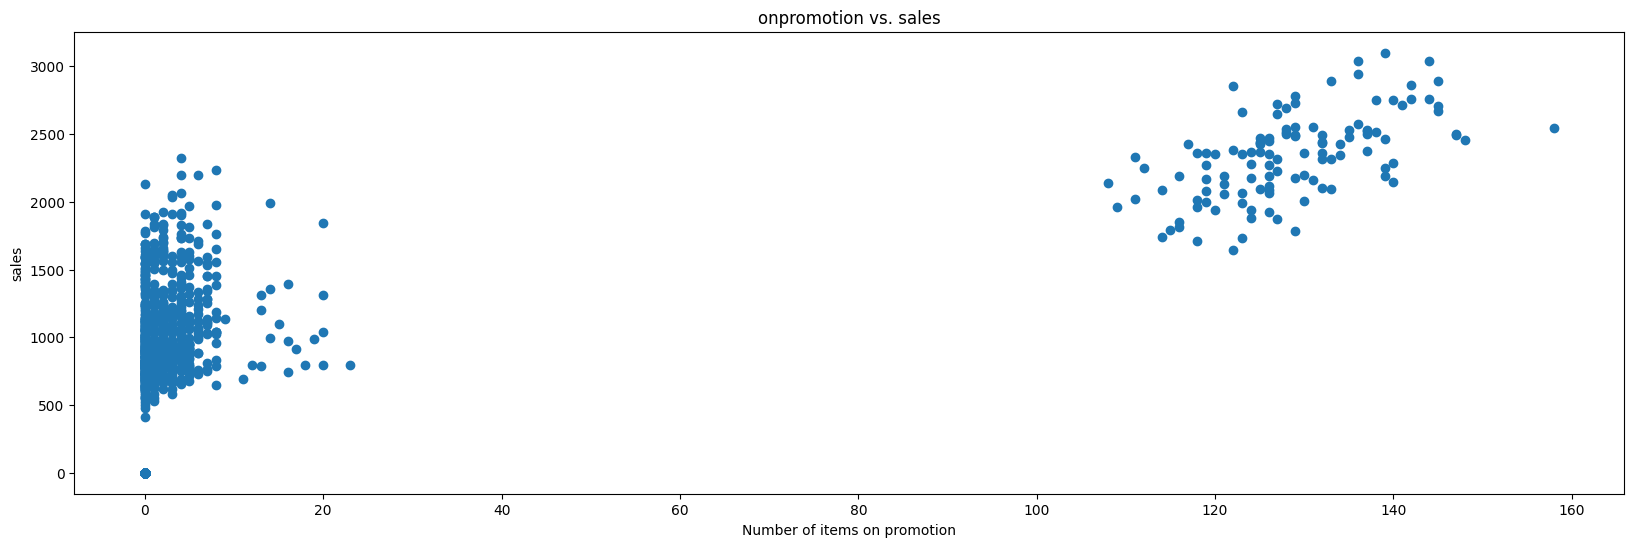

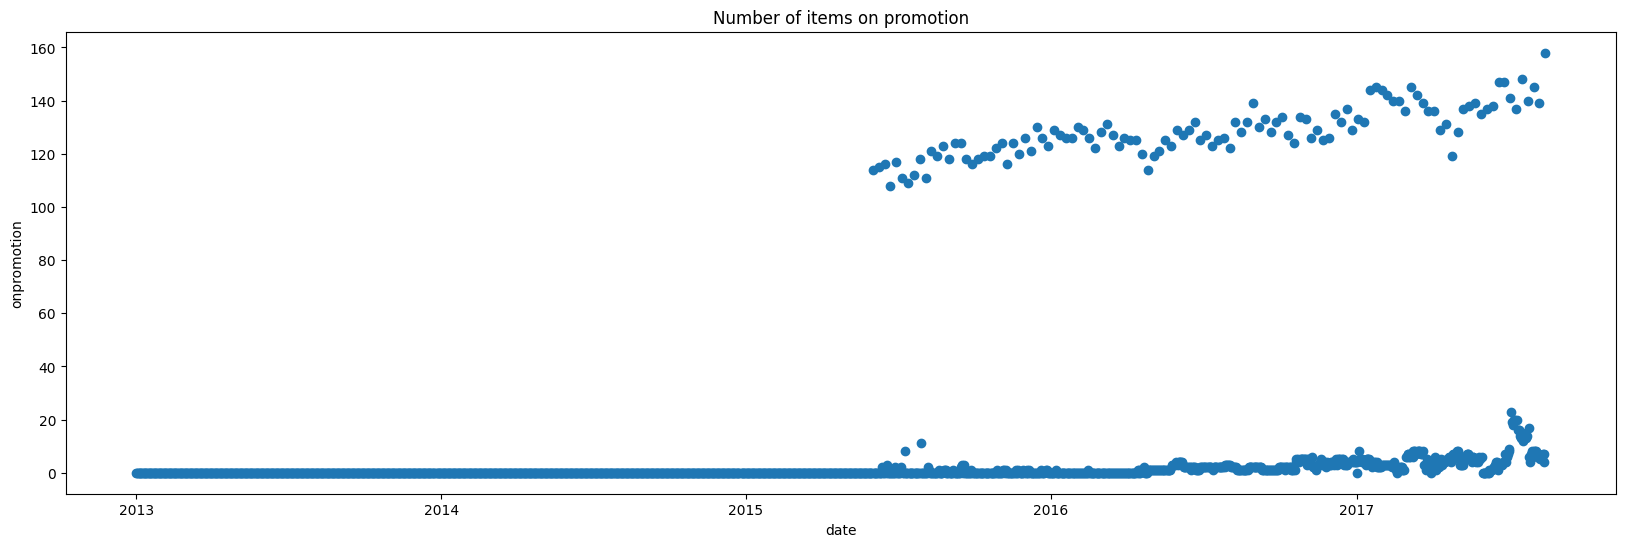

In [29]:
# Plots for the comb with high correlation with Onpromotion and comparitively high sales - 29_PRODUCE

# Onpromotion can be used as an input variable only for such combinations where correlation is high

plt.figure(figsize=(20, 6))
plt.plot(train_proc_sales[train_proc_sales['comb']=='29_PRODUCE']['onpromotion'], 
train_proc_sales[train_proc_sales['comb']=='29_PRODUCE']['sales'], marker='o', linewidth=0)
plt.xlabel('Number of items on promotion')
plt.ylabel('sales')
plt.title('onpromotion vs. sales')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(train_proc_sales[train_proc_sales['comb']=='29_PRODUCE']['date'], 
train_proc_sales[train_proc_sales['comb']=='29_PRODUCE']['onpromotion'], marker='o', linewidth=0)
plt.xlabel('date')
plt.ylabel('onpromotion')
plt.title('Number of items on promotion')
plt.show()

In [30]:
df_plot = train_proc_sales[train_proc_sales['comb']=='29_PRODUCE'].copy()
df_plot = df_plot[df_plot['date']>=df_plot[df_plot['sales']!=0]['date'].min()].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_plot['date'],
y=df_plot['sales'],
name='sales',
mode='lines+markers',
text=df_plot['date'].dt.strftime('%b %d, %Y, %a'),
hovertemplate='%{text}, %{y:.2f}'))
fig.add_trace(go.Scatter(x=df_plot[df_plot['onpromotion']>0]['date'],
y=df_plot[df_plot['onpromotion']>0]['sales'],
name='onpromotion',
mode='markers',
text=df_plot[df_plot['onpromotion']>0]['date'].dt.strftime('%b %d, %Y, %a'),
hovertemplate='%{text}, %{y:.2f}'))
fig.add_trace(go.Scatter(x=df_plot[df_plot['onpromotion']>100]['date'],
y=df_plot[df_plot['onpromotion']>100]['sales'],
name='onpromotion>100',
mode='markers',
text=df_plot[df_plot['onpromotion']>100]['date'].dt.strftime('%b %d, %Y, %a'),
hovertemplate='%{text}, %{y:.2f}'))
fig.update_layout(title='29_PRODUCE')
fig.show()

# Some items are on promotion on all dates towards from Apr 2016 but more 
# than 100 items are on promotion only on tuesdays and because of this there is high sales on tuesday

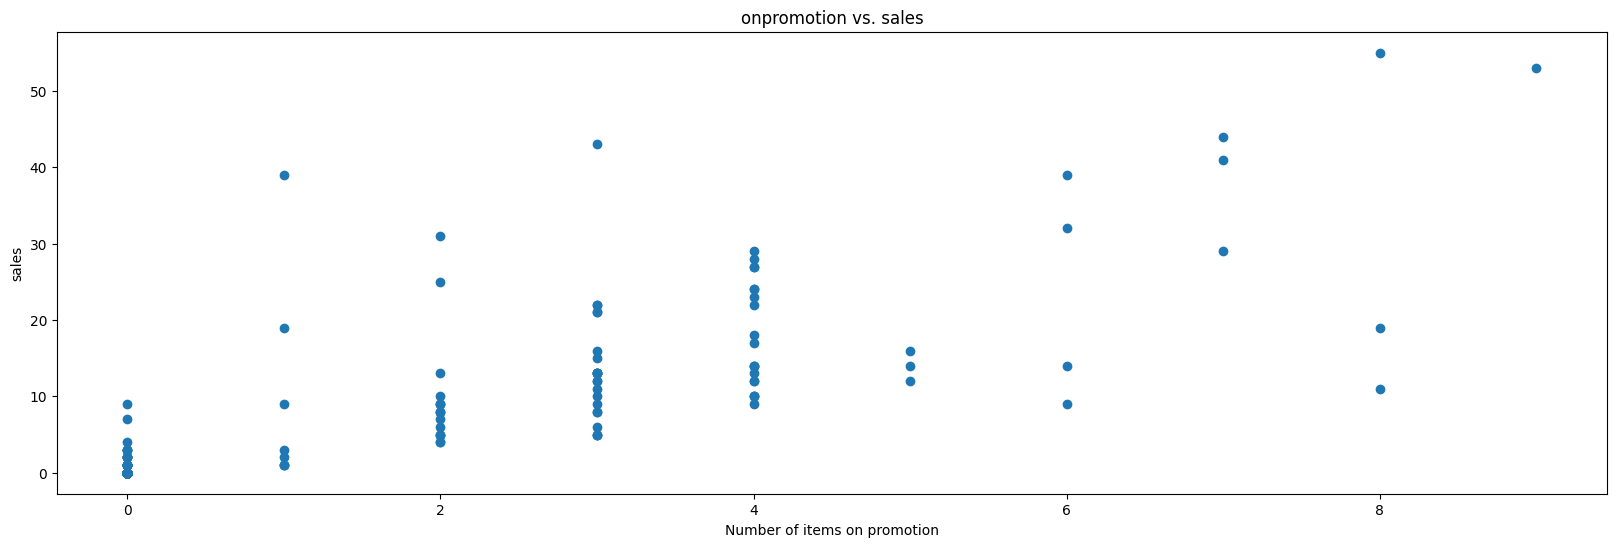

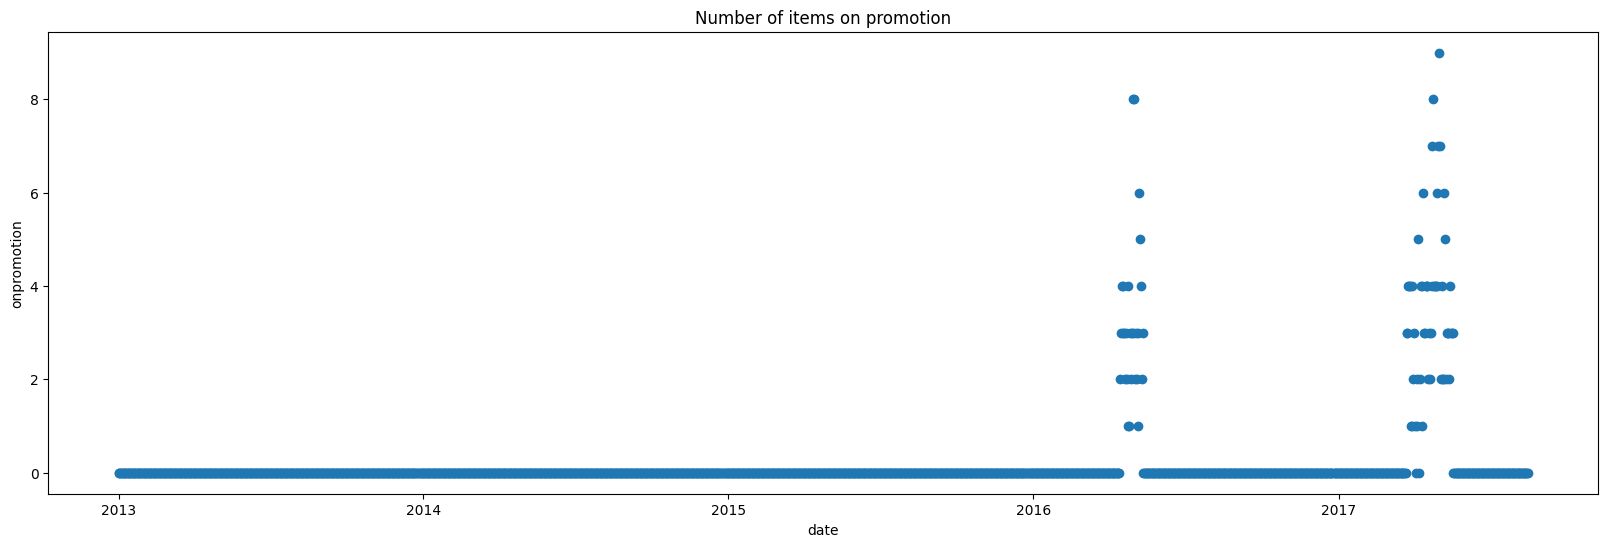

In [31]:
# Exploring other combs with very low avg sales value
# ['16_SCHOOL AND OFFICE SUPPLIES',
#  '30_SCHOOL AND OFFICE SUPPLIES',
#  '32_SCHOOL AND OFFICE SUPPLIES',
#  '33_SCHOOL AND OFFICE SUPPLIES',
#  '35_SCHOOL AND OFFICE SUPPLIES',
#  '36_SCHOOL AND OFFICE SUPPLIES',
#  '40_SCHOOL AND OFFICE SUPPLIES',
#  '50_SCHOOL AND OFFICE SUPPLIES', # High values are explained by promo
#  '54_SCHOOL AND OFFICE SUPPLIES'] # High values are explained by promo

comb_onpromo = '30_SCHOOL AND OFFICE SUPPLIES'

plt.figure(figsize=(20, 6))
plt.plot(train_proc_sales[train_proc_sales['comb']==comb_onpromo]['onpromotion'], 
train_proc_sales[train_proc_sales['comb']==comb_onpromo]['sales'], marker='o', linewidth=0)
plt.xlabel('Number of items on promotion')
plt.ylabel('sales')
plt.title('onpromotion vs. sales')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(train_proc_sales[train_proc_sales['comb']==comb_onpromo]['date'], 
train_proc_sales[train_proc_sales['comb']==comb_onpromo]['onpromotion'], marker='o', linewidth=0)
plt.xlabel('date')
plt.ylabel('onpromotion')
plt.title('Number of items on promotion')
plt.show()

df_plot = train_proc_sales[train_proc_sales['comb']==comb_onpromo].copy()
df_plot = df_plot[df_plot['date']>=df_plot[df_plot['sales']!=0]['date'].min()].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_plot['date'],
y=df_plot['sales'],
name='sales',
mode='lines+markers',
text=df_plot['date'].dt.strftime('%b %d, %Y, %a'),
hovertemplate='%{text}, %{y:.2f}'))
fig.add_trace(go.Scatter(x=df_plot[df_plot['onpromotion']>0]['date'],
y=df_plot[df_plot['onpromotion']>0]['sales'],
name='onpromotion',
mode='markers',
text=df_plot[df_plot['onpromotion']>0]['onpromotion'],
hovertemplate='%{x}, %{text}, %{y:.2f}'))
fig.update_layout(title=comb_onpromo)
fig.show()

# Some items are on promotion on all dates towards from Apr 2016 but more 
# than 100 items are on promotion only on tuesdays and because of this there is high sales on tuesday

#### Processing test data

In [32]:
test_proc = test.copy()
test_proc['comb'] = test_proc['store_nbr'].map(int).map(str) + '_' + test_proc['family']

# Indicator for combinations where forecast can directly be entered as 0
test_proc['no_sales'] = test_proc['comb'].map(lambda x: x in no_sales_combs)

print('Count of missing values present in test data:', test_proc.isna().sum().sum())

print('Unique store count:', test_proc['store_nbr'].nunique(), '\n', 
'Unique product family count:', test_proc['family'].nunique(),  '\n', 
'Unique store, product family combinations:', 
test_proc[['store_nbr', 'family']].drop_duplicates().shape[0])
print(54*33)

# 16 dates present for every store_nbr, family combination present in test data
print(len(test_proc), test_proc[['store_nbr', 'family']].drop_duplicates().shape[0]*16)

test_proc.head()

Count of missing values present in test data: 0
Unique store count: 54 
 Unique product family count: 33 
 Unique store, product family combinations: 1782
1782
28512 28512


,id,date,store_nbr,family,onpromotion,comb,no_sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,1_AUTOMOTIVE,False
1,3000889,2017-08-16,1,BABY CARE,0,1_BABY CARE,True
2,3000890,2017-08-16,1,BEAUTY,2,1_BEAUTY,False
3,3000891,2017-08-16,1,BEVERAGES,20,1_BEVERAGES,False
4,3000892,2017-08-16,1,BOOKS,0,1_BOOKS,False


#### Processing stores data

In [33]:
# Stores data
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [34]:
stores['city'].unique(), stores['state'].unique(), stores['type'].unique(), stores['cluster'].unique()

(array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
        'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
        'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
        'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
       dtype=object),
 array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
        'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
        'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
        'Esmeraldas', 'Manabi'], dtype=object),
 array(['D', 'B', 'C', 'E', 'A'], dtype=object),
 array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17],
       dtype=int64))

In [35]:
stores[['city', 'state']].drop_duplicates()

,city,state
0,Quito,Pichincha
4,Santo Domingo,Santo Domingo de los Tsachilas
10,Cayambe,Pichincha
11,Latacunga,Cotopaxi
13,Riobamba,Chimborazo
14,Ibarra,Imbabura
18,Guaranda,Bolivar
21,Puyo,Pastaza
22,Ambato,Tungurahua
23,Guayaquil,Guayas


In [36]:
# Adding column with top 5, top 10, top 20 (in terms of population) information for cities
stores_proc = stores.copy()
dict_city_pop = {'Quito': 1, 'Riobamba': 11, 'Guayaquil': 2, 'Ibarra':12, 'Cuenca': 3, 
'Esmeraldas':13, 'Santo Domingo': 4, 'Quevedo': 14, 'Ambato': 5, 'Latacunga': 15, 'Portoviejo': 6, 
'Milagro': 16, 'Durán': 7, 'Santa Elena': 17, 'Machala	El Oro': 8, 'Babahoyo': 18, 'Loja': 9, 
'Daule': 19, 'Manta':10, 'Quinindé': 20}
stores_proc['population'] = stores_proc['city'].map(lambda x: dict_city_pop.get(x, '>20'))
stores_proc['population'] = stores_proc['population'].astype(str)
stores_proc.head()

,store_nbr,city,state,type,cluster,population
0,1,Quito,Pichincha,D,13,1
1,2,Quito,Pichincha,D,13,1
2,3,Quito,Pichincha,D,8,1
3,4,Quito,Pichincha,D,9,1
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,4


In [37]:
stores_proc = stores_proc.merge(
    train_proc.groupby('store_nbr')['sales'].sum().reset_index().rename(
        columns={'sales': 'sales_sum'}), on='store_nbr', how='left')
stores_proc.head()

,store_nbr,city,state,type,cluster,population,sales_sum
0,1,Quito,Pichincha,D,13,1,14145012.87
1,2,Quito,Pichincha,D,13,1,21557388.64
2,3,Quito,Pichincha,D,8,1,50481910.19
3,4,Quito,Pichincha,D,9,1,18909700.38
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,4,15592404.57


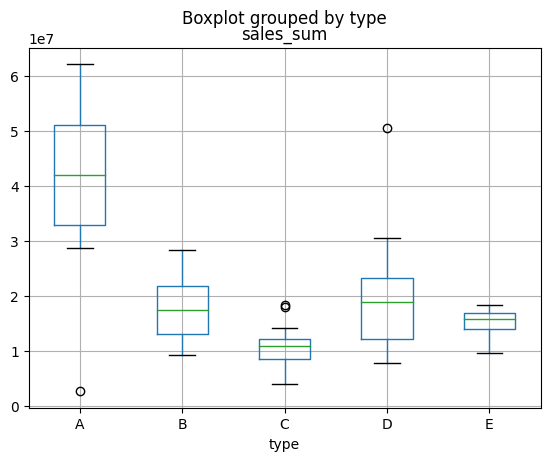

In [38]:
plt.close('all')
stores_proc.boxplot(column='sales_sum', by='type')
# A has stores with high sales sum, B, C, D, E kind of overlap
plt.show()

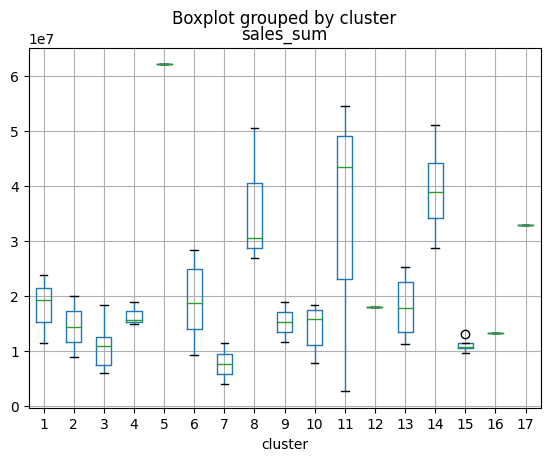

In [39]:
plt.close('all')
stores_proc.boxplot(column='sales_sum', by='cluster')
# There is lots of overlap
plt.show()

#### Processing oil data

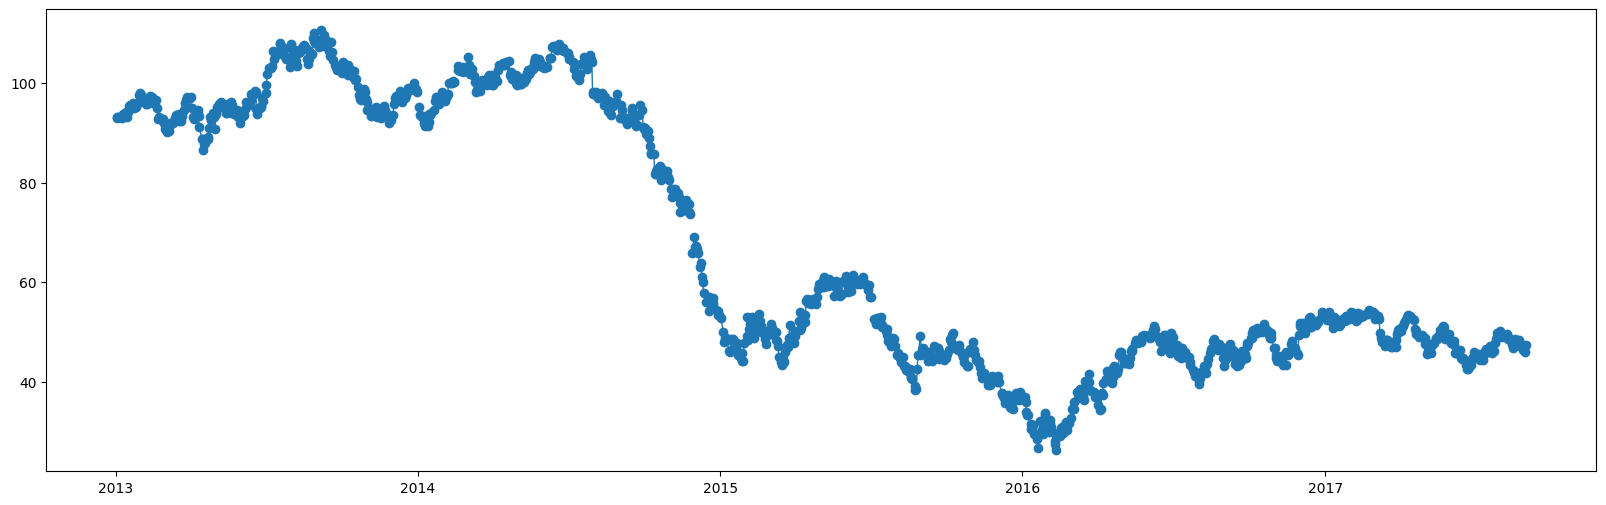

In [40]:
# oil data
oil['date'] = pd.to_datetime(oil['date'])

plt.close('all')
plt.figure(figsize=(20, 6))
plt.plot(oil['date'], oil['dcoilwtico'], marker='o', linewidth=1)
plt.show()

In [41]:
# Checking correlation of oil prices with top 5 combs with respect to avg sales
for i in range(1, 6):
    comb_chk_corr_oil = comb_info_tb[(comb_info_tb['Avg_sales']==
    comb_info_tb['Avg_sales'].sort_values().iloc[-i])]['comb'].unique()[0]
    
    df_chk_corr_oil = train_proc[train_proc['comb']==comb_chk_corr_oil].copy()
    df_chk_corr_oil = df_chk_corr_oil.merge(oil, on='date', how='left')

    print(f'Correlation sales vs. oil price: Comb {i} {comb_chk_corr_oil}', 
    round(pearsonr(df_chk_corr_oil.dropna()['sales'], 
    df_chk_corr_oil.dropna()['dcoilwtico'])[0], 3))
# Looks like there is negative correlation with oil prices. Higher the 
# price lower the money people have to spend on groceries

Correlation sales vs. oil price: Comb 1 44_GROCERY I -0.226
Correlation sales vs. oil price: Comb 2 45_GROCERY I -0.343
Correlation sales vs. oil price: Comb 3 47_GROCERY I -0.494
Correlation sales vs. oil price: Comb 4 46_GROCERY I -0.369
Correlation sales vs. oil price: Comb 5 44_BEVERAGES -0.608


In [42]:
print(oil.isna().sum())
print(data_start_date, data_end_date)

print(oil['date'].min(), oil['date'].max(), (oil['date'].max() - oil['date'].min()).days+1, len(oil))

oil_proc = oil.copy()
oil_proc = oil_proc.merge(pd.DataFrame({'date': 
pd.date_range(start=oil['date'].min(), end=oil['date'].max())}), on='date', how='right')

# Oil prices missing for 529 days
print(oil_proc.isna().sum())

# Missing values are not continuous. Missing oil prices in test period as well
print(oil_proc[oil_proc['dcoilwtico'].isna()]['date'].min(), 
oil_proc[oil_proc['dcoilwtico'].isna()]['date'].max(), 
(oil_proc[oil_proc['dcoilwtico'].isna()]['date'].max() - 
oil_proc[oil_proc['dcoilwtico'].isna()]['date'].min()).days+1)

date           0
dcoilwtico    43
dtype: int64
2013-01-01 00:00:00 2017-08-15 00:00:00
2013-01-01 00:00:00 2017-08-31 00:00:00 1704 1218
date            0
dcoilwtico    529
dtype: int64
2013-01-01 00:00:00 2017-08-27 00:00:00 1700


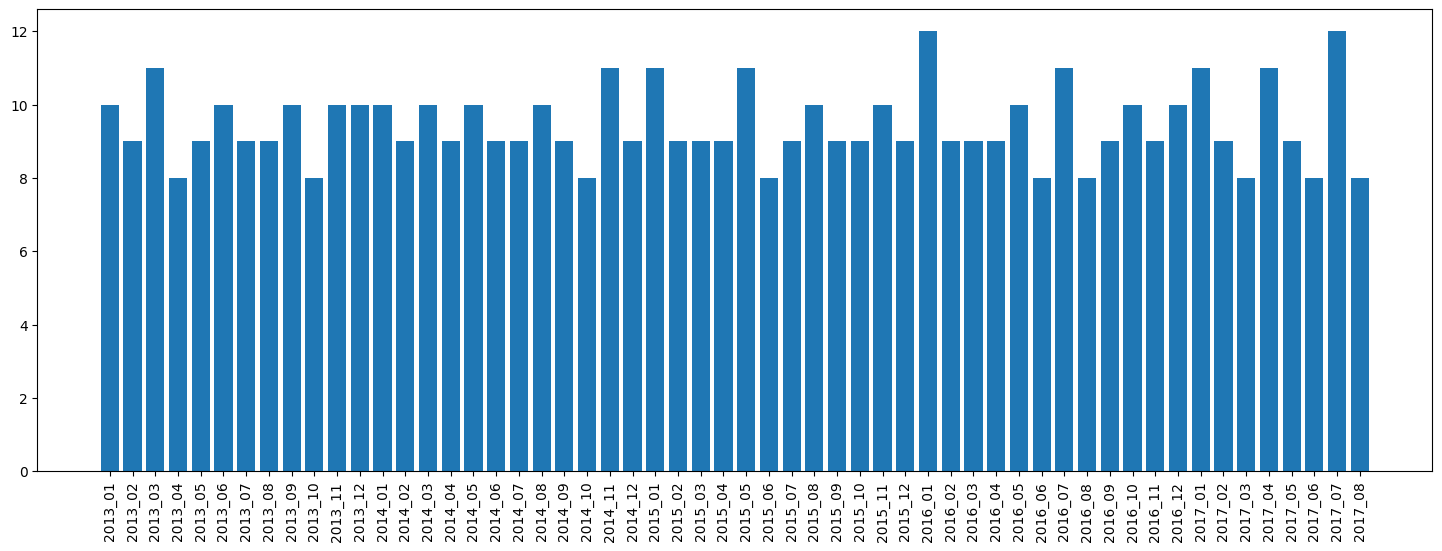

Saturday     243
Sunday       243
Monday        23
Friday         9
Thursday       7
Tuesday        2
Wednesday      2
Name: day, dtype: int64
Count Saturday and sundays for which oil price is available: 0


In [43]:
# Imputing missing values in oil prices
# If increase or decrease for consecutive days is not high then missing values can be imputed 
# with forward fill
oil_proc['year'] = oil_proc['date'].dt.year
oil_proc['month'] = oil_proc['date'].dt.month
oil_proc['year_month'] = (oil_proc['year'].map(int).map(str) + '_' + 
oil_proc['month'].map(int).map(str).map(lambda x:'0'+x if (len(x)==1) else x))
oil_proc['week'] = oil_proc['date'].dt.isocalendar().week
oil_proc['day'] = oil_proc['date'].dt.strftime("%A")

plt.close('all')
plt.figure(figsize=(18, 6))
missing_dates_dist = oil_proc[oil_proc['dcoilwtico'].isna()].groupby(
    'year_month')['date'].count().reset_index()
plt.bar(
    x=missing_dates_dist['year_month'], height=missing_dates_dist['date'])
plt.xticks(rotation=90)
plt.show()

print(oil_proc[oil_proc['dcoilwtico'].isna()]['day'].value_counts())

# Oil prices are not available for weekends
print('Count Saturday and sundays for which oil price is available:', 
oil_proc[(oil_proc['dcoilwtico'].isna()==False) &
(oil_proc['day'].isin(['Saturday', 'Sunday']))].shape[0])

       dcoilwtico  diff_wrt_prev
count     1175.00         922.00
mean        67.71           0.93
std         25.63           0.78
min         26.19           0.00
25%         46.41           0.33
50%         53.19           0.73
75%         95.66           1.32
max        110.62           6.06


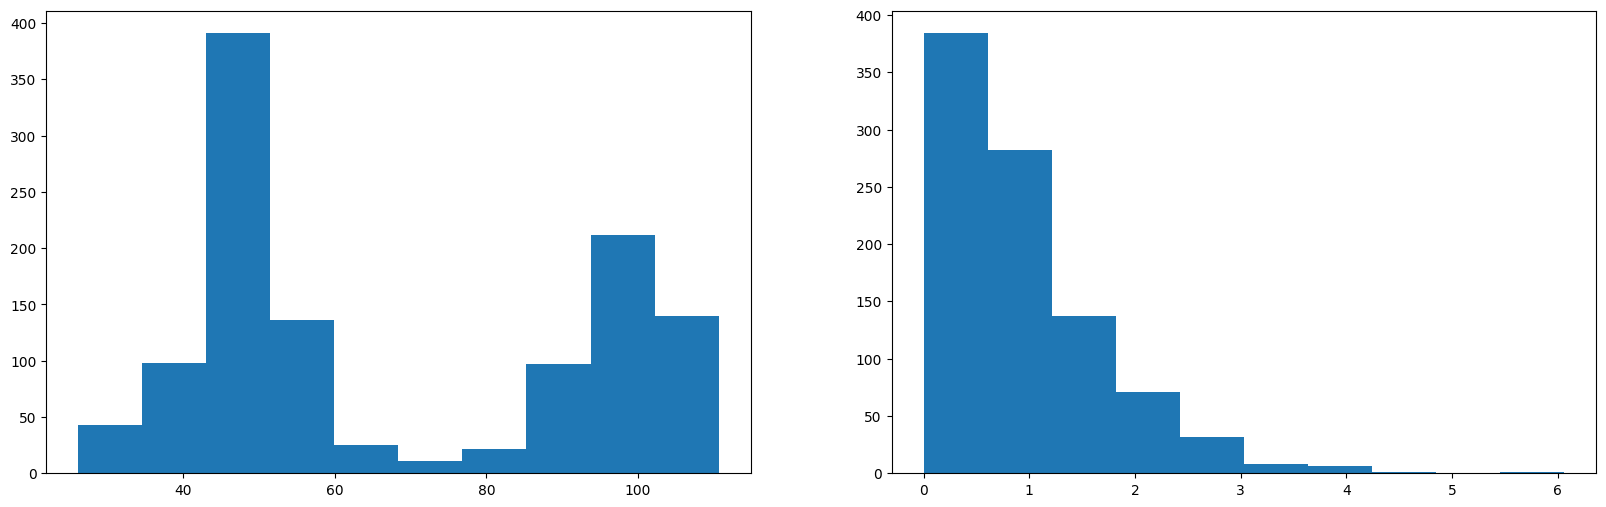

In [44]:
# Shift 1
oil_proc['dcoilwtico_tm1'] = oil_proc['dcoilwtico'].shift(1)
oil_proc['dcoilwtico_tp1'] = oil_proc['dcoilwtico'].shift(-1)
oil_proc['diff_wrt_prev'] = abs(oil_proc['dcoilwtico'] - oil_proc['dcoilwtico_tm1'])

print(oil_proc[['dcoilwtico', 'diff_wrt_prev']].describe())

# Since oil prices are not available for weekends, imputing missing values with forward fill might 
# not help with correlation with sales
# Maybe sum of oil prices at week level without imputing values for weekends might work. That way 
# weekly oil price might be correlated with sales and help in predicting changes in levels
# But impute values for week days so that sum is not affected

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax1.hist(oil_proc['dcoilwtico'])
ax2.hist(oil_proc['diff_wrt_prev'])
plt.show()

In [45]:
# Imputing prices for non-weekends
oil_proc['dcoilwtico_ffill'] = oil_proc['dcoilwtico'].ffill()
oil_proc['dcoilwtico_imputed'] = np.where(
    (oil_proc['dcoilwtico'].isna()) & (oil_proc['day'].isin(['Saturday', 'Sunday'])==False),
    oil_proc['dcoilwtico_ffill'], oil_proc['dcoilwtico']
    )

oil_proc_weekly = oil_proc.groupby(['year', 'week'])[
    'dcoilwtico_imputed'].sum().reset_index().rename(
        columns={'dcoilwtico_imputed': 'weekly_oil_price'})
oil_proc_weekly.head()

,year,week,weekly_oil_price
0,2013,1,476.30
1,2013,2,466.90
2,2013,3,472.91
3,2013,4,477.26
4,2013,5,486.66


In [46]:
# Checking correlation of oil prices with top 5 combs with respect to avg sales
for i in range(1, 6):
    comb_chk_corr_oil = comb_info_tb[(comb_info_tb['Avg_sales']==
    comb_info_tb['Avg_sales'].sort_values().iloc[-i])]['comb'].unique()[0]
    
    df_chk_corr_oil = train_proc[train_proc['comb']==comb_chk_corr_oil].copy()
    df_chk_corr_oil['year'] = df_chk_corr_oil['date'].dt.year
    df_chk_corr_oil['week'] = df_chk_corr_oil['date'].dt.isocalendar().week

    df_chk_corr_oil_dt = df_chk_corr_oil.merge(oil_proc, on=['date'], how='left')
    print('Missing values: ', df_chk_corr_oil_dt.isna().sum().sum())
    df_chk_corr_oil = df_chk_corr_oil.merge(oil_proc_weekly, on=['year', 'week'], how='left')
    print('Missing values: ', df_chk_corr_oil.isna().sum().sum())
    print(f'Correlation sales vs. oil price: Comb {i} {comb_chk_corr_oil}', 
    round(pearsonr(df_chk_corr_oil.dropna()['sales'], 
    df_chk_corr_oil.dropna()['weekly_oil_price'])[0], 3), 
    round(pearsonr(df_chk_corr_oil_dt.dropna()['sales'], 
    df_chk_corr_oil_dt.dropna()['dcoilwtico'])[0], 3))
# Correlation has reduced with weekly sum of oil prices. Need to check if there's a different way to 
# use it

Missing values:  2823
Missing values:  0
Correlation sales vs. oil price: Comb 1 44_GROCERY I -0.223 -0.173
Missing values:  2823
Missing values:  0
Correlation sales vs. oil price: Comb 2 45_GROCERY I -0.317 -0.37
Missing values:  2823
Missing values:  0
Correlation sales vs. oil price: Comb 3 47_GROCERY I -0.356 -0.495
Missing values:  2823
Missing values:  0
Correlation sales vs. oil price: Comb 4 46_GROCERY I -0.264 -0.402
Missing values:  2823
Missing values:  0
Correlation sales vs. oil price: Comb 5 44_BEVERAGES -0.481 -0.586


#### Processing transactions data

In [47]:
# transactions data
transactions['date'] = pd.to_datetime(transactions['date'])
print(transactions['date'].min(), transactions['date'].max())
transactions.head()

2013-01-01 00:00:00 2017-08-15 00:00:00


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [48]:
transactions_proc = transactions.copy()
transactions_proc = transactions_proc.merge(
    train_proc.groupby(['date', 'store_nbr'])['sales'].sum(), 
    on=['date', 'store_nbr'], how='left')
# Transaction count and sales are highly correlated as expected. But 
# this data is not available for test period
print('Correlation between sales and transaction count:', 
 pearsonr(transactions_proc['sales'], transactions_proc['transactions'])[0])

Correlation between sales and transaction count: 0.8373836801431711


<Figure size 1500x400 with 0 Axes>

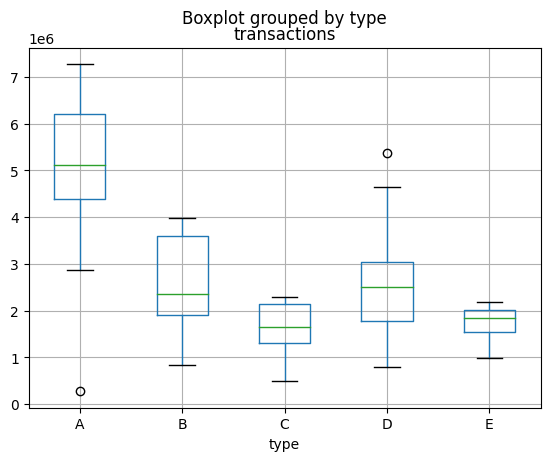

<Figure size 1500x400 with 0 Axes>

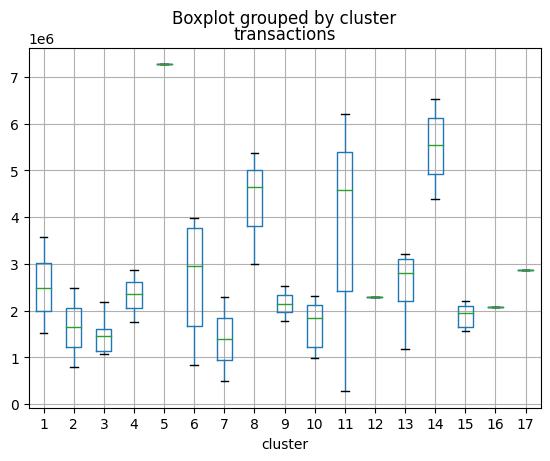

In [49]:
transactions_proc = transactions_proc.merge(
    stores_proc[['store_nbr', 'type', 'cluster']], 
    on=['store_nbr'], how='left')
transactions_proc.head()

# Type and cluster doesn't seem to be clearly impacted by transaction count either (except for type A)
plt.close('all')
plt.figure(figsize=(15, 4))
transactions_proc.groupby(['store_nbr', 'type'])['transactions'].sum().reset_index().boxplot(
    column='transactions', by='type')
plt.show()

plt.close('all')
plt.figure(figsize=(15, 4))
transactions_proc.groupby(['store_nbr', 'cluster'])['transactions'].sum().reset_index().boxplot(
    column='transactions', by='cluster')
plt.show()

In [50]:
# Is imputing missing weeks with 0 meaningful?

# Seasonality/ trend present in data?

# ACF, PACF

In [51]:
#  - complete eda
#  - which combs to apply time series models to
#  - multiple seasonality?
#  - identify features for machine learning models
# You have to forecasts 15 days forward